- Nigerian economies rely on the dollar exchange rate to Naira, and the conversion rate has a strong influence on the Nigerian economy for things like buying goods, paying for services, doing international business, and so on. Over the years, there has been a constant fluctuation in the conversion rate, which causes a lot of dilemmas for Nigerian citizens. The challenge is open to statisticians, mathematicians, data scientists, machine learning enthusiasts, and all disciplines in the AI domain. The goal of the project is to build a time series or machine learning model that will accurately forecast what the naira rate against the dollar will be in the next 2 weeks, ranging from May 22, 2024, to June 4, 2024.
- The Deep Learning Indaba is the annual meeting of the African machine learning and AI community. Since 2017, our mission has been to Strengthen African AI, and to ensure that Africans are owners and shapers of the coming advances in AI. As an educational charity, our work focuses on learning, teaching, research, and the role work of peer learning and community building.
- The evaluation metric for this competition is Root Mean Squared Error.
- Documentation : 
A README markdown file is required- 

It should cove :

How to set up folders and where each file is saved
Order in which to run code
Explanations of features used
Environment for the code to be run (conda environment.yml file or an environment.txt file)
Hardware needed (e.g. Google Colab or the specifications of your local machine)
Expected run time for each notebook. This will be useful to the review team for time and resource allocation.
Your code needs to run properly, code reviewers do not have time to debug code. If code does not run easily you will be bumped down the leaderboard.

## Data assesment and Data cleaning

In [1]:
#install and download needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
#from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
warnings.filterwarnings('ignore') 

In [2]:
train= pd.read_csv('Competition_data.csv')
submission_data= pd.read_csv('submission.csv')

In [3]:
train.head()

,Date,Close
0,1/1/2023 23:58:00,448.08
1,1/2/2023 23:58:00,448.08
2,1/3/2023 23:58:00,448.55
3,1/4/2023 23:58:00,449.01
4,1/5/2023 23:58:00,449.53


In [4]:
train.tail()

,Date,Close
481,5/2/2024 23:58:00,1372.95
482,5/3/2024 23:58:00,1382.50
483,5/4/2024 23:58:00,1382.50
484,5/5/2024 23:58:00,1393.74
485,5/6/2024 23:58:00,1384.00


In [5]:
train.shape

(486, 2)

In [6]:
train.dtypes

Date      object
Close    float64
dtype: object

In [7]:
### Remove time
train['Date'] = train['Date'].apply(lambda x:x.split(' ')[0])
train['Date']=pd.to_datetime(train['Date'])

In [8]:
train.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [9]:
train.set_index('Date', inplace=True)

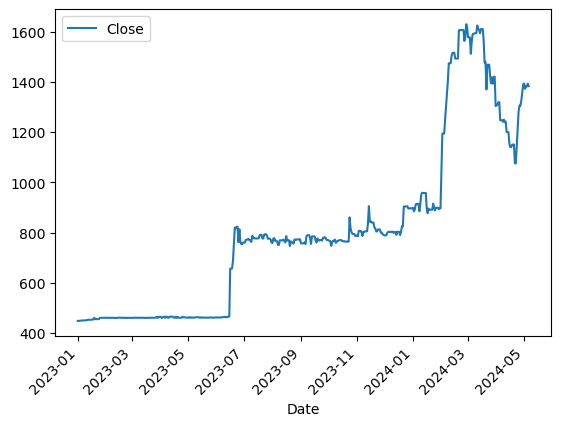

In [10]:
train.plot.line(y='Close', use_index=True)
plt.xticks(rotation=45) ;

In [11]:
train.describe()

,Close
count,486.000000
mean,801.034228
std,341.494007
min,448.080000
25%,461.500000
50%,772.105000
75%,895.500000
max,1630.660000


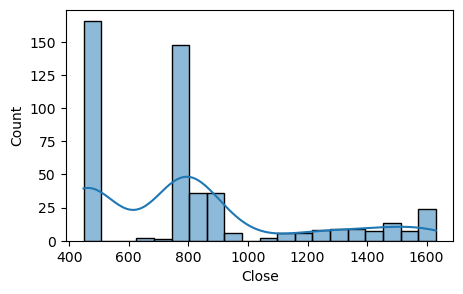

In [12]:
plt.figure(figsize=[5,3])
sns.histplot(data=train, x='Close', bins=20, kde=True);


In [13]:
train.head()

,Close
Date,
2023-01-01,448.08
2023-01-02,448.08
2023-01-03,448.55
2023-01-04,449.01
2023-01-05,449.53


In [14]:
train.tail()

,Close
Date,
2024-05-02,1372.95
2024-05-03,1382.50
2024-05-04,1382.50
2024-05-05,1393.74
2024-05-06,1384.00


In [15]:
#train.iloc[401,:]

In [16]:
#train_data = train.loc['2023-01-01':'2024-02-09']
#valid_data = train.loc['2024-02-10':'2024-05-06']

In [17]:
### The test set ranges from May 22 to June 4th
#date_range = pd.date_range(start='2024-05-22', end='2024-06-04', freq='D')
#test = pd.DataFrame(date_range, columns=['Date']) 
#test 

In [18]:
### Cross validation
#train_data = train[:400] ## we use the date from January 1 2023 to April 30 2024 to train our model
#valid_data = train[400:] ## we use the date May 1 to May 6 to validate the performance of our model

In [19]:
#train_close = train_data['Close'] ## Our target feature (Close)
#valid_close = valid_data['Close'] 

## Feature Engineering and Feature Selection

#add additional predictors to the model
#calculate the mean close price in certain days and  find the ratio between today's closing price and that of the periods
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = competition_data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    competition_data[ratio_column] = competition_data["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    competition_data[trend_column] = competition_data.shift(1).rolling(horizon).sum()["Close"]
    
    
    
    new_predictors+= [ratio_column, trend_column]

In [20]:
train.shape

(486, 1)

In [21]:
#Create the RSI indicator
#data['rsi' + str(n)] = talib.RSI(data['close'].values, timeperiod=horizon)
def computeRSI (competition_data, time_window):
    diff = competition_data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [22]:
train['RSI']= computeRSI(train['Close'], 14)

In [23]:
train['mom'] = train['Close'].pct_change(12) # 12 month change

In [24]:
train=train.dropna()
train.shape

(472, 3)

In [25]:
train['SMA_3'] = train.iloc[:,1].rolling(window=3).mean()
train['SMA_4'] = train.iloc[:,1].rolling(window=4).mean()
train['EMA'] = train.iloc[:,1].ewm(span=40,adjust=False).mean()

In [26]:
train=train.dropna()
train.shape

(469, 6)

In [27]:
train['previousday']=train['Close'].shift(1)

In [28]:
train=train.dropna()
train.shape

(468, 7)

In [29]:
train.head()

,Close,RSI,mom,SMA_3,SMA_4,EMA,previousday
Date,,,,,,,
2023-01-19,460.50,100.00000,0.023220,100.00000,100.000000,100.000000,453.58
2023-01-20,455.06,62.85955,0.011132,87.61985,90.714888,98.188271,460.50
2023-01-21,455.06,62.85955,0.011132,75.23970,81.429775,96.464919,455.06
2023-01-22,455.06,62.85955,0.011065,62.85955,72.144663,94.825632,455.06
2023-01-23,455.06,62.85955,0.007662,62.85955,62.859550,93.266311,455.06



# Parameters
fast_length = 23
slow_length = 50
cycle_length = 10
stochastic_length = 10

def ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

# Step 1: Calculate MACD line
competition_data['EMA_fast'] = ema(competition_data['Close'], fast_length)
competition_data['EMA_slow'] = ema(competition_data['Close'], slow_length)
competition_data['MACD'] = competition_data['EMA_fast'] - competition_data['EMA_slow']

# Step 2: Calculate MACD signal line
competition_data['MACD_signal'] = ema(competition_data['MACD'], cycle_length)

# Step 3: Calculate Stochastic %K and %D of the MACD line
competition_data['Stochastic_K'] = ((competition_data['MACD'] - competition_data['MACD'].rolling(window=stochastic_length).min()) /
                      (competition_data['MACD'].rolling(window=stochastic_length).max() - competition_data['MACD'].rolling(window=stochastic_length).min())) * 100

competition_data['Stochastic_D'] = competition_data['Stochastic_K'].rolling(window=3).mean()  # Typically, %D is a 3-period SMA of %K

# Step 4: Calculate the Schaff Trend Cycle (STC)
competition_data['STC'] = ema(competition_data['Stochastic_D'], cycle_length)

# Clean up
competition_data.drop(['EMA_fast', 'EMA_slow', 'MACD_signal', 'Stochastic_K', 'Stochastic_D'], axis=1, inplace=True)

# Display the dataframe with STC
print(competition_data.tail(2))


In [30]:
#competition_data=competition_data.dropna()
train.columns

Index(['Close', 'RSI', 'mom', 'SMA_3', 'SMA_4', 'EMA', 'previousday'], dtype='object')

In [31]:
train_data = train.loc['2023-01-19':'2024-02-27']
valid_data = train.loc['2024-02-28':'2024-05-06']

In [32]:
train_data.shape, valid_data.shape

((401, 7), (67, 7))

In [33]:
X_train = train_data.drop(columns=['Close'])
y_train = train_data['Close']
X_valid = valid_data.drop(columns=['Close'])
y_valid = valid_data['Close']

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(401, 6)
(401,)
(67, 6)
(67,)


In [35]:
# Utility function
from sklearn.metrics import mean_squared_error
def evaluate_model(model, x, y):
    """
    Utility function to print the model performance, (MAE and MAPE)
    model: Fitted model
    x:  features dataset
    y:  target values
    """
    predicted = model.predict(x) #get predictions
    mse = mean_squared_error(y_true=y, y_pred=predicted, squared= False)
    rmse= np.sqrt(mse)
   

    print('RMSE: {:.2f}'.format(rmse))
    print()

In [36]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {
          'RF Regressor':RandomForestRegressor(random_state=0),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0)
         }

#looping through all the regressors, fitting and evaluating them on  test data respectively
for key, model in models_dict.items():
    model.fit(X_train, y_train)
    print(f'Performance of "{key}" on Test set:')
    print("**"*8)
    evaluate_model(model, X_valid, y_valid) 

Performance of "RF Regressor" on Test set:
****************
RMSE: 10.14

Performance of "xgboost" on Test set:
****************
RMSE: 11.76

Performance of "Gradient Boost" on Test set:
****************
RMSE: 9.48



In [ ]:
pip install tensorflow

In [67]:
# List of machine learning algorithms to consider
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
algorithms = [
    ('Linear regression', LinearRegression(), {}),
    ('Ridge', Ridge(), {}),
    ('Lasso', Lasso(), {}),
    ('Elastic Net', ElasticNet(), {}),
    ('MLP', MLPRegressor(), {})
]

# Train base models
base_models = {}
for algorithm_name, algorithm, _ in algorithms:
    print(algorithm)
    model = algorithm
    model.fit(X_train, y_train)
    base_models[algorithm_name] = model

eval_metrics = ['rmse']
results = pd.DataFrame(columns=['Algorithm'] + eval_metrics)

for algorithm_name, model in base_models.items():
    y_pred = model.predict(X_valid)
    mse= mean_squared_error(y_valid, y_pred, squared=False)
    rmse= np.sqrt(mse)
    
# Ensembling using Stacking
meta_model = Ridge()
stacking_model = StackingRegressor(estimators=list(base_models.items()), final_estimator=meta_model)
stacking_model.fit(X_train, y_train)
stacking_y_pred = stacking_model.predict(X_valid)
stacking_mse =  mean_squared_error(y_valid, stacking_y_pred, squared= False)
stacking_rmse = np.sqrt(stacking_mse)

print(f"Stacking Ensemble Method Performance Metrics \n\n \
stacking rmse: {stacking_rmse} \n")

ModuleNotFoundError: No module named 'tensorflow'

In [38]:
X_train.head()

,RSI,mom,SMA_3,SMA_4,EMA,previousday
Date,,,,,,
2023-01-19,100.00000,0.023220,100.00000,100.000000,100.000000,453.58
2023-01-20,62.85955,0.011132,87.61985,90.714888,98.188271,460.50
2023-01-21,62.85955,0.011132,75.23970,81.429775,96.464919,455.06
2023-01-22,62.85955,0.011065,62.85955,72.144663,94.825632,455.06
2023-01-23,62.85955,0.007662,62.85955,62.859550,93.266311,455.06


In [39]:
X_train.columns

Index(['RSI', 'mom', 'SMA_3', 'SMA_4', 'EMA', 'previousday'], dtype='object')

In [40]:
# Create test set for the forecast period (May 22 to June 4, 2024)
date_range = pd.date_range(start='2024-05-22', end='2024-06-04', freq='D')
test = pd.DataFrame(date_range, columns=['Date'])
#future_df['RSI'] = [i.RSI for i in future_dates]
test.set_index('Date', inplace=True)
test

""
Date
2024-05-22
2024-05-23
2024-05-24
2024-05-25
2024-05-26
2024-05-27
2024-05-28
2024-05-29
2024-05-30


In [65]:


# Define your feature columns, including 'lag_1', 'lag_2', 'lag_3', and any other features used during training
feature_cols = ['lag_1', 'lag_2', 'lag_3', 'RSI', 'mom', 'SMA_3', 'SMA_4', 'EMA', 'previousday']

# Create lag features for training data
for i in range(1, 4):
    train[f'lag_{i}'] = train['Close'].shift(i)

# Drop rows with NaN values generated by shifting and rolling
train = train.dropna()

# Split the data into training and validation sets
train_data = train.loc['2023-01-19':'2024-02-27']
valid_data = train.loc['2024-02-28':'2024-05-06']

# Split train into X and y
X_train = train_data[feature_cols]
y_train = train_data['Close']
X_valid = valid_data[feature_cols]
y_valid = valid_data['Close']

# Assuming stacking_model is already defined and fitted
# stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model.fit(X_train, y_train)

# Create test set for the forecast period (May 22 to June 4, 2024)
date_range = pd.date_range(start='2024-05-22', end='2024-06-04', freq='D')
test = pd.DataFrame(date_range, columns=['Date'])
test.set_index('Date', inplace=True)

# Initialize the test DataFrame with the last available data
last_data = train.iloc[-3:]  # Get the last 3 rows (for lag features)
test_features = []

# Helper function to compute RSI
def computeRSI(series, period):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI.iloc[-1] if not RSI.empty else 0

# Generate lag features for the forecast period dynamically
for date in test.index:
    last_close = last_data['Close'].values
    new_row = {
        'lag_1': last_close[-1],
        'lag_2': last_close[-2],
        'lag_3': last_close[-3],
        'RSI': computeRSI(last_data['Close'], 14),
        'mom': last_data['Close'].pct_change(12).iloc[-1] if not last_data['Close'].pct_change(12).dropna().empty else 0,
        'SMA_3': last_data['Close'].rolling(window=3).mean().iloc[-1] if not last_data['Close'].rolling(window=3).mean().dropna().empty else 0,
        'SMA_4': last_data['Close'].rolling(window=4).mean().iloc[-1] if not last_data['Close'].rolling(window=4).mean().dropna().empty else 0,
        'EMA': last_data['Close'].ewm(span=3, adjust=False).mean().iloc[-1] if not last_data['Close'].ewm(span=3, adjust=False).mean().dropna().empty else 0,
        'previousday': last_close[-1]
    }

    # Ensure there are no NaN values in the new_row
    new_row = {k: (v if pd.notna(v) else 0) for k, v in new_row.items()}

    test_features.append(new_row)
    # Update last_data with the new predicted value
    new_row_df = pd.DataFrame([new_row]).fillna(0)
    new_prediction = stacking_model.predict(new_row_df)[0]
    new_data = pd.DataFrame({'Close': [new_prediction]}, index=[date])
    last_data = pd.concat([last_data, new_data]).iloc[1:]  # Keep the last 3 rows only

# Convert test_features to DataFrame
test_features = pd.DataFrame(test_features, index=test.index)

# Ensure there are no NaN values in the test_features DataFrame
test_features = test_features.fillna(0)

# Make predictions for the forecast period
predictions = stacking_model.predict(test_features)

# Create submission DataFrame
submission = test.copy()
submission['Close'] = predictions.round(2)

# Save the submission
submission.reset_index(inplace=True)
submission.to_csv('base3.csv', index=False)

print(submission)


         Date        Close
0  2024-05-22      4247.90
1  2024-05-23      8359.93
2  2024-05-24     16310.07
3  2024-05-25     33254.83
4  2024-05-26     66994.41
5  2024-05-27    134762.61
6  2024-05-28    271544.17
7  2024-05-29    546968.51
8  2024-05-30   1101644.36
9  2024-05-31   2218947.65
10 2024-06-01   4469394.88
11 2024-06-02   9002188.48
12 2024-06-03  18132108.68
13 2024-06-04  36521483.37


In [ ]:
# Convert test_features to DataFrame
test_features = pd.DataFrame(test_features, index=test.index)

# Make predictions for the forecast period
predictions = stacking_model.predict(test_features)

# Create submission DataFrame
submission = test.copy()
submission['Close'] = predictions.round(2)

# Save the submission
submission.reset_index(inplace=True)
submission.to_csv('base3.csv', index=False)

print(submission)